In [1]:
#! pip install ultralytics 
#! pip install psycopg2
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import psycopg2
#import im_utils
import db_ops
import pandas as pd
import im_utils

import cv2

import tensorflow as tf
print(tf.__version__)

from keras.models import Model
from keras.saving import load_model

from ultralytics import YOLO

Connecting to the PostgreSQL database...
Connection successful


2024-07-25 09:44:59.129438: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-25 09:44:59.154217: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-25 09:44:59.154272: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-25 09:44:59.169406: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-25 09:45:00.217469: W tensorflow/compiler/tf

2.16.2


In [3]:
test_lbls = ['5-hour energy', '99', 'AW', 'Acadia', 'Arizona Tea', 'Bang', 'Big Gulp', 'Bill Miller', 'Boulevard Brewing', 'Brisk', 'Bud', 'Budweiser', 'Burger King', 'Busch', 'Camel', 'Cheetos', 'Coca Cola', 'Coors', 'Corona', 'Dasani', 'Dasy', 'David', 'Deer Park', 'Dorritos', 'Dunkin Donuts', 'Evan Williams', 'Fanta', 'Fireball', 'Flow', 'Fruit Punch', 'Gatorade', 'GoGo', 'Google', 'Goya', 'Grace', 'Green Mountain', 'Heineken', 'Hersheys', 'Hill Country Fair', 'Icehouse Edge', 'Jarritos', 'Jim Beam', 'Kirkland', 'Kit Kat', 'Kool-Aid', 'La Yogurt', 'LaCroix', 'Lays', 'Lybbis', 'Marlboro', 'McDonalds', 'Mentos', 'Michelob', 'Miller', 'Milwakee Best Ice', 'MnM', 'Modelo', 'Monster', 'Mountain Dew', 'Natural Ice', 'New Amsterdam', 'Niagara', 'Oreo', 'Pabst Blue Ribbon', 'Pacifico', 'Pampers', 'Parliament', 'Peaceful Fruits', 'Perrier', 'Poland Spring', 'Popeyes', 'PurAqua', 'Redbull', 'Ross Ouzo', 'Sams Club', 'Samuel Adams', 'Sangria Senorial', 'Sanpple', 'Seven eleven', 'Shasta', 'Silver Falls', 'Slurpee', 'Smirnoff', 'Snickers', 'Sprite', 'Stella Artois', 'Turkey Hill', 'Twix', 'Two Ball', 'Vitamin', 'Welchs', 'Yoohoo']

In [31]:
label_path = '../random_test_dataset/train/labels'
lbl_files = os.listdir(label_path)
file_names = []
labels = []
lst_cent_x = []
lst_cent_y = []
lst_box_w = []
lst_box_h = []

for file in lbl_files:
    file_name = file.split('_jpg')[0]
    with open(label_path + '/'+file, 'r') as label_file:
        for line in label_file:
            idx, cent_x, cent_y, box_w, box_h = line.split(' ')
            lst_cent_x.append(float(cent_x))
            lst_cent_y.append(float(cent_y))
            lst_box_w.append(float(box_w))
            lst_box_h.append(float(box_h))
            labels.append(test_lbls[int(idx)].lower())
            file_names.append(file_name)
        
test_labels_df = pd.DataFrame({'im_name':file_names,
                               'label': labels,
                                'cent_x': lst_cent_x,
                                'cent_y': lst_cent_y,
                                'box_w': lst_box_w,
                                'box_h': lst_box_h}, index = range(len(file_names)))
test_labels_df['box_id'] = range(len(test_labels_df))

In [5]:
image_path = '../random_test_dataset/train/images'
files = os.listdir(image_path)
image_names = [file.split('_jpg')[0] for file in files]

In [56]:
'''
# load image classification model
classifier = load_model("./models/B0_EffNet_classifier.keras")

# load dataframe that correlated model index and database ID
id_idx_df = pd.read_csv('brand_ids_idx.csv', sep = '\t')

# load logo detection model
detector = YOLO('./models/logo_detector.pt')
'''

'\n# load image classification model\nclassifier = load_model("./models/B0_EffNet_classifier.keras")\n\n# load dataframe that correlated model index and database ID\nid_idx_df = pd.read_csv(\'brand_ids_idx.csv\', sep = \'\t\')\n\n# load logo detection model\ndetector = YOLO(\'./models/logo_detector.pt\')\n'

In [54]:
'''
# Detection stage
boxes_df = pd.DataFrame(columns = ['im_name', 'xmin_coord', 'ymin_coord', 'xmax_coord', 'ymax_coord', 'box_conf', 'brand', 'brand_predicted'])

for file in files:
    print('-'*30)
    try:
        # Scale the image and write to the local folder  
        image_original = cv2.imread(os.path.join(image_path, file))
        image_scaled = im_utils.ScaleImage(image_original, width = 640)
        
        # Run logo detector
        results = detector(image_scaled, conf = 0.25)
        
        # Find the saceling factor
        w_ratio = image_original.shape[1]/image_scaled.shape[1]
        h_ratio = image_original.shape[0]/image_scaled.shape[0]
        for i in range(len(results[0].boxes.xyxy)):   # Iterate over each box
            # Get the coordinates of the box on the original image
            xmin, ymin, xmax, ymax = map(int, results[0].boxes.xyxy[i]) 
            xmin = int(xmin * w_ratio)
            xmax = int(xmax * w_ratio)
            ymin = int(ymin * h_ratio)
            ymax = int(ymax * h_ratio)

            # Get the section of the original image that is in the box
            box_im = image_original[ymin:ymax, xmin:xmax,:]

            # Run the logo classifier on this box
            box_im = cv2.resize(box_im, (254,254))
            y_pred = classifier.predict(box_im.reshape(1,254,254,3))
            y_pred_dense = np.argmax(y_pred, axis=1)
            brand_name_df = id_idx_df[id_idx_df['idx'] == y_pred_dense[0]]
            
            # Save the box locally as an individual file
            idx = len(boxes_df)
            boxes_df.loc[idx, 'im_name'] = file.split('_jpg')[0]
            boxes_df.loc[idx, 'xmin_coord'] = xmin
            boxes_df.loc[idx, 'ymin_coord'] = ymin
            boxes_df.loc[idx, 'xmax_coord'] = xmax
            boxes_df.loc[idx, 'ymax_coord'] = ymax
            boxes_df.loc[idx, 'box_conf'] = float(results[0].boxes.conf[i])
            boxes_df.loc[idx, 'brand_conf'] = max(y_pred[0])
            boxes_df.loc[idx, 'brand_predicted'] = brand_name_df['brand_name'].iloc[0]
    except Exception as e:
        print(e)

# Save predictions 
boxes_df.to_csv('EffNet_boxes.csv', sep='\t', index=False)
'''

"\n# Detection stage\nboxes_df = pd.DataFrame(columns = ['im_name', 'xmin_coord', 'ymin_coord', 'xmax_coord', 'ymax_coord', 'box_conf', 'brand', 'brand_predicted'])\n\nfor file in files:\n    print('-'*30)\n    try:\n        # Scale the image and write to the local folder  \n        image_original = cv2.imread(os.path.join(image_path, file))\n        image_scaled = im_utils.ScaleImage(image_original, width = 640)\n        \n        # Run logo detector\n        results = detector(image_scaled, conf = 0.25)\n        \n        # Find the saceling factor\n        w_ratio = image_original.shape[1]/image_scaled.shape[1]\n        h_ratio = image_original.shape[0]/image_scaled.shape[0]\n        for i in range(len(results[0].boxes.xyxy)):   # Iterate over each box\n            # Get the coordinates of the box on the original image\n            xmin, ymin, xmax, ymax = map(int, results[0].boxes.xyxy[i]) \n            xmin = int(xmin * w_ratio)\n            xmax = int(xmax * w_ratio)\n           

In [37]:
# Read saved predictions to not re-run the prediction job
boxes_df_read = pd.read_csv('EffNet_boxes.csv', sep='\t')
boxes_df_read['box_id'] = range(len(test_labels_df), len(test_labels_df) + len(boxes_df_read))

/tmp/ipykernel_192324/3476646945.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_labels_df['xmin_coord'] = (im_w * true_labels_df['cent_x'] - 0.5*im_w*true_labels_df['box_w']).astype(int)
/tmp/ipykernel_192324/3476646945.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_labels_df['xmax_coord'] = (im_w * true_labels_df['cent_x'] + 0.5*im_w*true_labels_df['box_w']).astype(int)
/tmp/ipykernel_192324/3476646945.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

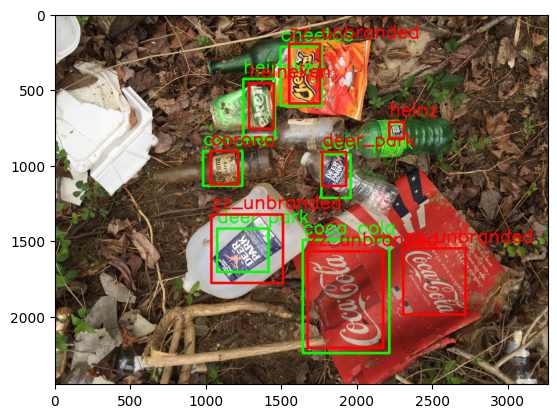

In [64]:
#def convert_ratio_to_px(im_name, x1, x2, y1, y2):
im_name = 'GeD4DMMUJxBugDKeF1Z61VAmWVDiMPvPFl1p27s8'
file_name = [file_name for file_name in files if im_name in file_name][0]
file_path = os.path.join(image_path, file_name)
im_orig = cv2.imread(file_path)
im_h, im_w = im_orig.shape[:2]

# Draw ground truth boxes:
#Get the slice for this image
true_labels_df = test_labels_df[test_labels_df['im_name'] == im_name]
#Convert the YOLO notation to coordinates
true_labels_df['xmin_coord'] = (im_w * true_labels_df['cent_x'] - 0.5*im_w*true_labels_df['box_w']).astype(int)
true_labels_df['xmax_coord'] = (im_w * true_labels_df['cent_x'] + 0.5*im_w*true_labels_df['box_w']).astype(int)
true_labels_df['ymin_coord'] = (im_h * true_labels_df['cent_y'] - 0.5*im_h*true_labels_df['box_h']).astype(int)
true_labels_df['ymax_coord'] = (im_h * true_labels_df['cent_y'] + 0.5*im_h*true_labels_df['box_h']).astype(int)
# for each box, draw the box and label
for box_params in true_labels_df[['label', 'xmin_coord', 'ymin_coord', 'xmax_coord', 'ymax_coord']].values:
    lbl, x1, y1, x2, y2 = box_params
    color = (0,255,0)
    cv2.rectangle(im_orig, (x1,y1), (x2,y2), color, 15)
    cv2.putText(im_orig, lbl, (x1,y1-40), cv2.FONT_HERSHEY_SIMPLEX, 4, color, 10, cv2.LINE_AA)
    #cv2.putText(im_orig, f"Conf: {int(conf)}", (x1,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 5, cv2.LINE_AA)

# Draw predicted boxes 
pred_labels_df = boxes_df_read[boxes_df_read['im_name']==im_name]
for box_params in pred_labels_df[['brand_predicted', 'xmin_coord', 'ymin_coord', 'xmax_coord', 'ymax_coord']].values:
    lbl, x1, y1, x2, y2 = box_params
    color = (0,0,255)
    cv2.rectangle(im_orig, (x1,y1), (x2,y2), color, 15)
    cv2.putText(im_orig, lbl, (x1,y1-40), cv2.FONT_HERSHEY_SIMPLEX, 4, color, 10, cv2.LINE_AA)

#Show the picture
plt.imshow(cv2.cvtColor(im_orig, cv2.COLOR_BGR2RGB))
plt.show()

In [101]:
def bb_iou(boxA, boxB):
    #print(f'BoxA: {boxA}')
    #print(f'BoxB: {boxB}')
    y_max = max(boxA[3], boxB[3])
    x_max = max(boxA[2], boxB[2])
    field = np.zeros((y_max, x_max))
    field[:,:] = False
    #print(f'Field shape: {field.shape}')
    maskA = field.copy()
    maskA[boxA[1]:boxA[3], boxA[0]:boxA[2]] = True
    maskB = field.copy()
    maskB[boxB[1]:boxB[3], boxB[0]:boxB[2]] = True
    intersection = (np.logical_and(maskA, maskB)).sum()
    union = (np.logical_or(maskA, maskB)).sum()
    iou = intersection / float(union)
    #print(f'inter: {intersection}, union: {union}, IoU: {iou}')

    # return the intersection over union value
    return iou

In [103]:
dict_IoU = {}
i = 0
boxA = true_labels_df['xmin_coord'].iloc[i], true_labels_df['ymin_coord'].iloc[i], true_labels_df['xmax_coord'].iloc[i], true_labels_df['ymax_coord'].iloc[i] 
for j in range(len(pred_labels_df)):
    boxB = pred_labels_df['xmin_coord'].iloc[j], pred_labels_df['ymin_coord'].iloc[j], pred_labels_df['xmax_coord'].iloc[j], pred_labels_df['ymax_coord'].iloc[j] 
    dict_IoU[pred_labels_df['box_id'].iloc[j]] = bb_iou(boxA, boxB)
dict_IoU

{446: 0.4544480770484627,
 447: 0.0,
 448: 0.0,
 449: 0.0,
 450: 0.0,
 451: 0.0,
 452: 0.0,
 453: 0.0}